# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.


__Признаки__
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

__Целевой признак__
- Price — цена (евро)

## Подготовка данных

Заполним пропущенные значения и обработаем аномалии в столбцах. 

Если среди признаков имеются неинформативные, удалим их.

In [1]:
# импортируем нужные нам библиотеки

import pandas as pd
import numpy as np

import time
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
# отключим некритические предупреждения в коде

warnings.filterwarnings("ignore")

In [3]:
# загрузим наш файл 'autos.csv'

try:
    data = pd.read_csv('/Users/alex/Downloads/autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv')

In [4]:
# определим и присвоим глобальную переменную для дальнейшего использования

STATE = np.random.RandomState(42)

In [5]:
# выведим первые 5 строк

display(data.head())
display(data.shape)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


(354369, 16)

In [6]:
# приведем столбцы к нижнему/привычному регистру

data.columns = (data.columns
                .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex = True)
                .str.lower()
               )

In [7]:
data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [9]:
# проверим наш дф на дубликаты

data.duplicated().sum()

4

In [10]:
# удалим их

data.drop_duplicates(inplace = True)
data.duplicated().sum()

0

In [11]:
data.shape

(354365, 16)

Рассмотрим наши данные поближе и выявим аномалии, начнем с registration_year

In [12]:
data['registration_year'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

In [13]:
# последняя дата скачивания

data['date_crawled'].max()

'2016-04-07 14:36:58'

Имеются явно аномальные значения такие как 8500, 9229 и т.д так и года близкие к нашей дате скачивания анкеты - 2016 год, что можно посчитать как анкеты из будущего, взлянем на них

In [14]:
data.query('registration_year > 2016')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25 00:00:00,0,48499,2016-03-31 21:47:44
51,2016-03-07 18:57:08,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07 00:00:00,0,66115,2016-03-07 18:57:08
57,2016-03-10 20:53:19,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10 00:00:00,0,33397,2016-03-25 10:17:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354112,2016-03-11 15:49:51,3600,NaN,2017,manual,86,transit,150000,5,gasoline,ford,NaN,2016-03-11 00:00:00,0,32339,2016-03-12 05:45:02
354140,2016-03-29 16:47:29,1000,NaN,2017,manual,101,a4,150000,9,NaN,audi,NaN,2016-03-29 00:00:00,0,38315,2016-04-06 02:44:27
354203,2016-03-17 00:56:26,2140,NaN,2018,manual,80,fiesta,150000,6,NaN,ford,no,2016-03-17 00:00:00,0,44866,2016-03-29 15:45:04
354253,2016-03-25 09:37:59,1250,NaN,2018,NaN,0,corsa,150000,0,petrol,opel,NaN,2016-03-25 00:00:00,0,45527,2016-04-06 07:46:13


Имеется 14530, что является менее 5% строк , избавимся от них

In [15]:
data = data.query('registration_year < 2017')
data.shape

(339835, 16)

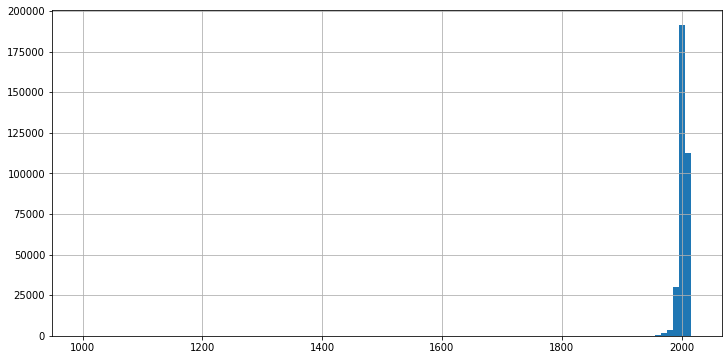

In [16]:
data['registration_year'].hist(bins = 100, figsize = (12, 6));

Взглянем на нижний порог аномальных годов, для понимания отнимим 50 лет и взгялнем сколько у нас имеется строк

In [17]:
data.query('registration_year < 1964')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
622,2016-03-16 16:55:09,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-16 00:00:00,0,44628,2016-03-20 16:44:37
1928,2016-03-25 15:58:21,7000,suv,1945,manual,48,other,150000,2,petrol,volkswagen,no,2016-03-25 00:00:00,0,58135,2016-03-25 15:58:21
2273,2016-03-15 21:44:32,1800,convertible,1925,NaN,0,NaN,5000,1,NaN,sonstige_autos,no,2016-03-15 00:00:00,0,79288,2016-04-07 05:15:34
3333,2016-03-15 21:36:20,10500,sedan,1955,manual,30,other,60000,0,petrol,ford,NaN,2016-03-15 00:00:00,0,53498,2016-04-07 08:16:11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351682,2016-03-12 00:57:39,11500,NaN,1800,NaN,16,other,5000,6,petrol,fiat,NaN,2016-03-11 00:00:00,0,16515,2016-04-05 19:47:27
352529,2016-03-30 18:56:24,10000,sedan,1961,manual,80,other,125000,11,petrol,volvo,no,2016-03-30 00:00:00,0,71334,2016-04-07 10:17:13
353531,2016-03-16 21:56:55,6000,sedan,1937,manual,38,other,5000,0,petrol,mercedes_benz,NaN,2016-03-16 00:00:00,0,23936,2016-03-30 18:47:41
353961,2016-03-17 13:54:22,200,NaN,1910,NaN,0,NaN,5000,0,petrol,sonstige_autos,NaN,2016-03-17 00:00:00,0,42289,2016-03-31 22:46:47


Всего 754 строки, избавимся от них

In [18]:
data = data.query('registration_year > 1964')
data.shape

(339017, 16)

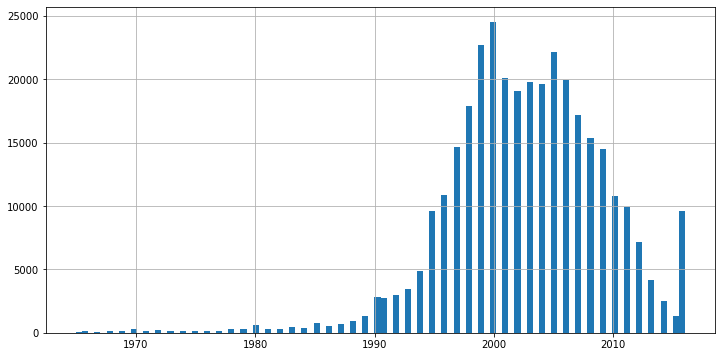

In [19]:
data['registration_year'].hist(bins = 100, figsize = (12, 6));

Далее рассмотрим мощность - __power__

In [20]:
data['power'].describe()

count    339017.000000
mean        111.157134
std         187.006099
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

Возьмем как потолок - мощность равную в 1500 л.с.

In [21]:
data = data.query('power < 1500')

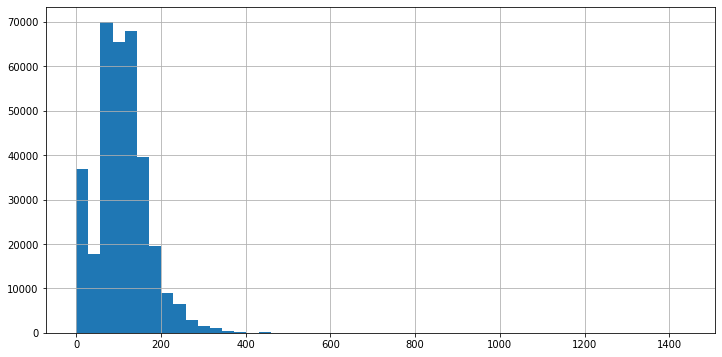

In [22]:
data['power'].hist(bins = 50, figsize = (12,6));

остановимся на 500 и всех тех - что выше 0 

In [23]:
data = data.query('0 < power < 500')
data.shape

(302492, 16)

Погуглив, наткнулся на автомобили у которых мощность бывает в районе 10л.с , в других источниках есть авто у которых один целиндр и 6.5л.с но там что то совсем старое, будем считать аномалии до 10л.с и удалим аномалии

In [24]:
data.query('1<power<10')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
431,2016-03-20 20:45:27,3950,small,2004,auto,5,NaN,70000,5,gasoline,sonstige_autos,no,2016-03-20 00:00:00,0,90562,2016-04-03 04:17:08
3349,2016-03-29 17:37:58,1990,small,2004,NaN,7,polo,150000,5,gasoline,volkswagen,no,2016-03-29 00:00:00,0,37124,2016-04-02 05:16:40
9561,2016-04-04 07:58:34,9000,sedan,2009,manual,2,a4,5000,12,gasoline,audi,NaN,2016-04-04 00:00:00,0,12045,2016-04-06 10:17:01
12747,2016-03-24 16:38:53,2850,small,2005,auto,5,NaN,40000,8,gasoline,sonstige_autos,no,2016-03-24 00:00:00,0,56825,2016-04-07 08:44:59
16228,2016-04-02 22:47:03,2500,small,2006,auto,5,NaN,40000,1,gasoline,sonstige_autos,yes,2016-04-02 00:00:00,0,78532,2016-04-04 21:17:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346667,2016-03-08 19:50:27,3700,small,2006,auto,5,NaN,40000,4,gasoline,sonstige_autos,no,2016-03-08 00:00:00,0,50769,2016-04-05 15:45:35
348975,2016-03-19 21:53:10,1850,small,2003,auto,5,NaN,50000,3,gasoline,sonstige_autos,yes,2016-03-19 00:00:00,0,13347,2016-04-03 14:44:50
349666,2016-03-07 21:36:46,1500,NaN,2016,NaN,2,NaN,150000,5,gasoline,volkswagen,NaN,2016-03-07 00:00:00,0,33330,2016-03-19 10:48:08
353127,2016-03-26 18:53:12,8600,convertible,2012,manual,8,NaN,5000,3,gasoline,sonstige_autos,no,2016-03-26 00:00:00,0,82399,2016-04-06 08:17:29


In [25]:
data = data.query('power > 10')
data.shape

(302269, 16)

Взглянем на прайс - __price__


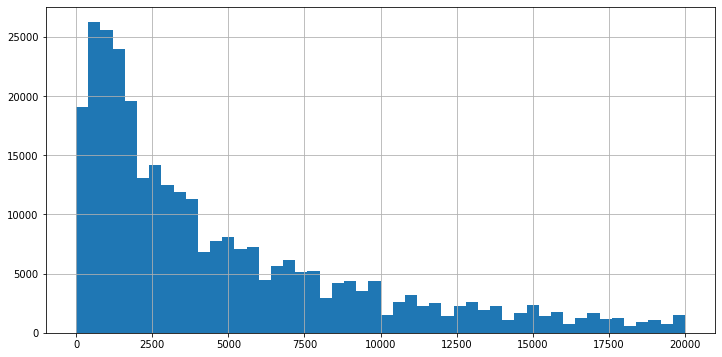

In [26]:
data['price'].hist(bins = 50, figsize = (12, 6));

Имеются 0-вые значение 

In [27]:
data['price'].describe()

count    302269.000000
mean       4746.177620
std        4610.212931
min           0.000000
25%        1250.000000
50%        3000.000000
75%        6900.000000
max       20000.000000
Name: price, dtype: float64

In [28]:
data = data.query('price > 0')
data.shape

(295910, 16)

Спросив у алисыGPT "можно ликупить авто до 100 евро ответ был таков - Боюсь, что за такую сумму можно купить разве что игрушечный автомобиль(c)Алиса))", пошел дальше ... а за 200? - ответ уже был более  информативный - "За такую сумму можно попытаться найти очень старый и не очень рабочий автомобиль. Но зачем?"... решено - примем за аномалии значения ниже 200 евро

In [29]:
# взглянем на аномалии
data.query('price <200')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29 00:00:00,0,53721,2016-04-06 01:44:38
79,2016-03-17 18:52:56,150,NaN,2016,manual,75,astra,150000,3,petrol,opel,yes,2016-03-17 00:00:00,0,78315,2016-04-05 03:45:22
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28 00:00:00,0,40589,2016-04-06 12:15:54
268,2016-03-12 07:26:49,1,sedan,1990,manual,90,80,70000,6,petrol,audi,no,2016-03-11 00:00:00,0,55122,2016-03-26 23:15:49
281,2016-03-24 11:48:01,150,NaN,2016,auto,75,fiesta,50000,1,petrol,ford,yes,2016-03-24 00:00:00,0,32457,2016-03-30 11:48:26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353673,2016-03-24 11:55:15,90,small,1998,manual,60,other,150000,8,petrol,citroen,yes,2016-03-24 00:00:00,0,55278,2016-03-27 08:16:16
354015,2016-03-28 19:44:25,175,small,1997,manual,58,twingo,150000,1,petrol,renault,NaN,2016-03-28 00:00:00,0,21727,2016-04-07 01:46:34
354117,2016-03-28 14:38:14,1,wagon,1993,auto,217,5er,150000,12,petrol,bmw,NaN,2016-03-28 00:00:00,0,22941,2016-04-06 18:19:15
354273,2016-03-16 15:47:56,150,small,1993,manual,55,astra,150000,3,petrol,opel,yes,2016-03-16 00:00:00,0,66424,2016-04-06 17:46:29


In [30]:
# исключим их
data = data.query('price > 200')
data.shape

(290719, 16)

Из условия нам указали  "Если среди признаков имеются неинформативные, удалите их"  считаю таковыми:
- дата скачивания (date_crawled)
- месяц регистрации (registration_month)
- дата создания анкеты (date_created)
- количество фотографий (number_of_pictures)
- почтовый индекс (postal_code)
- последний визит/активность (last_seen)

удалим данные фичи из нашего дф

In [31]:
data.drop(['date_crawled',
           'registration_month',
           'date_created',
           'number_of_pictures',
           'postal_code',
           'last_seen'],
            axis = 1, inplace = True)

In [32]:
data.head(3)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no


Перейдем к заполнению пропусков

In [33]:
data.isna().sum()

price                    0
vehicle_type         10102
registration_year        0
gearbox               5001
power                    0
model                10469
kilometer                0
fuel_type            14541
brand                    0
repaired             40913
dtype: int64

начнем с __model__ - модель авто

In [34]:
data['model'].unique()

array([nan, 'grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'other', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'one', 'fortwo', '1er',
       'b_klasse', 'a8', 'jetta', 'fiesta', 'c_klasse', 'micra', 'vito',
       'sprinter', '156', 'escort', 'forester', 'xc_reihe', 'scenic',
       'ka', 'a1', 'focus', 'a4', 'tt', 'astra', 'a6', 'jazz', 'omega',
       'slk', '7er', 'combo', 'corsa', '80', '147', 'z_reihe', 'sorento',
       'ibiza', 'mustang', 'eos', 'touran', 'getz', 'insignia', 'almera',
       'megane', 'a3', 'lupo', 'r19', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'berlingo', 'tiguan', '6_reihe', 'c4',
       'panda', 'up', 'i_reihe', 'ceed', 'kangoo', '5_reihe', 'yeti',
       'octavia', 'zafira', 'mii', 'rx_reihe', '6er', 'modus', 'fox',
       'matiz', 'beetle', 'rio', 'touareg', 'logan', 'spider', 'cuore',
       's_m

Так как нет четкого представления откуда и почему появились пропуски предлагаю заполнить пропуски новой категорией 'unknown'

In [35]:
data['model'] = data['model'].fillna(value = "unknown")

__vehicle_type__ - тип кузова, запоним модальным значением сгруппировав по бренду и модели

In [36]:
data['vehicle_type'] = data.groupby(['brand', 'model'])['vehicle_type'].transform(lambda x: x.fillna((x.mode()[0])))

тоже самое проделаем с __gearbox__ - коробкой и __fuel_type__ типом топлива

In [37]:
data['gearbox'] = data.groupby(['brand', 'model'])['gearbox'].transform(lambda x: x.fillna((x.mode()[0])))
data['fuel_type'] = data.groupby(['brand', 'model'])['fuel_type'].transform(lambda x: x.fillna((x.mode()[0])))

осталось __repaired__ - была ли машина в ремонте, раполним значением "no", тк скорее всего владельцы просто посчитали ненужным заполнять это поле тк автомобиль не был в авариях , или просто человечиский фактор и тд в любом случае другого более точного понимания в заполнении у нас нет

In [38]:
data['repaired'] = data['repaired'].fillna(value = 'no')

In [39]:
data['gearbox'].unique()

array(['manual', 'auto'], dtype=object)

сразу же заменим в столбцах __repaired__ и __gearbox__ значения __no - 0 , yes - 1 и manual - 0 , auto - 1__ соответсветсвенно, дабы получился булев тип

In [40]:
data['repaired'] = data['repaired'].map({'no': 0, 'yes': 1})
data['gearbox'] = data['gearbox'].map({'manual': 0, 'auto': 1})

In [41]:
data.head(3)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,0,190,unknown,125000,gasoline,audi,1
2,9800,suv,2004,1,163,grand,125000,gasoline,jeep,0
3,1500,small,2001,0,75,golf,150000,petrol,volkswagen,0


In [42]:
data.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

Промежуточный вывод

на данном этапе мы проделали следующее:
1. избавились от аномалий в столцах 
    - registration_year 
    - power
    - price
2. удалили неинформотивные для дальнейшего обучения моделей столбцы
3. заполнили пропуски
4. проверили и удалили дубликаты

In [43]:
# взгялнем еще раз на дубликаты
data.duplicated().sum()

47748

In [44]:
# удалим их
data.drop_duplicates(inplace = True)
data.duplicated().sum()

0

## Обучение моделей

Подготовьте выборки для обучения моделей.

Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг.

Будем использовать следующие модели

- Линейная регрессия 
- Дерево решений 
- LightGBM
- Catboost

In [47]:
# перемешаем дф и разделим его на 60/20/20


train, valid, test = np.split(data.sample(frac = 1, random_state = 123), [int(.6 * len(data)), int(.8 * len(data))])

features_train = train.drop(['price'], axis = 1)
target_train = train['price']

features_valid = valid.drop(['price'], axis = 1)
target_valid = valid['price']

features_test = test.drop(['price'], axis = 1)
target_test = test['price']


print(f'Размер тренировочной части: {round(train.shape[0])}, соотношение: {round(train.shape[0] / data.shape[0], 2)}')
print(f'Размер валидационной части: {round(valid.shape[0])}, соотношение: {round(valid.shape[0] / data.shape[0], 2)}')
print(f'Размер тестовой части: {round(test.shape[0])}, соотношение: {round(test.shape[0] / data.shape[0], 2)}')

Размер тренировочной части: 145782, соотношение: 0.6
Размер валидационной части: 48594, соотношение: 0.2
Размер тестовой части: 48595, соотношение: 0.2


т.к модель LinearRegression, а так же наше DecisionTreeRegressor не умеют работать с категориальными признаками, применим функцию __dummies__ к этим признакам и стандартизируем числовые признаки

In [48]:
data_dum = pd.get_dummies(data, drop_first = True)
data_dum.head()

,price,registration_year,gearbox,power,kilometer,repaired,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,...,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo
1,18300,2011,0,190,125000,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9800,2004,1,163,125000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1500,2001,0,75,150000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,3600,2008,0,69,90000,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,650,1995,0,102,150000,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [52]:
train_dum, valid_dum, test_dum = np.split(data_dum.sample(frac = 1, random_state = 123),
                                          [int(.6 * len(data)), int(.8 * len(data))])

features_train_dum = train_dum.drop(['price'], axis = 1)
target_train_dum = train_dum['price']

features_valid_dum = valid_dum.drop(['price'], axis = 1)
target_valid_dum = valid_dum['price']

features_test_dum = test_dum.drop(['price'], axis = 1)
target_test_dum = test_dum['price']

С помощью standardscaler'a стандартизируем наши числовые признаки

In [53]:
# создадим список числовых признаков

numer = ['power', 'kilometer', 'registration_year']

In [54]:
# создадим объект скейлера

scaler = StandardScaler()
scaler.fit(features_train_dum[numer])

features_train_dum[numer] = scaler.transform(features_train_dum[numer])
features_valid_dum[numer] = scaler.transform(features_valid_dum[numer])
features_test_dum[numer] = scaler.transform(features_test_dum[numer])

__LinearRegression__


In [55]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train_dum, target_train_dum)

CPU times: user 9.77 s, sys: 3.41 s, total: 13.2 s
Wall time: 13.2 s


LinearRegression()

In [56]:
%%time

predict_lr = model_lr.predict(features_train_dum)
rmse_lr = mean_squared_error(target_train_dum, predict_lr)**0.5

print(f'RMSE модели линейная регрессия равна: {round(rmse_lr, 2)}')

RMSE модели линейная регрессия равна: 2673.47
CPU times: user 184 ms, sys: 141 ms, total: 325 ms
Wall time: 296 ms


In [57]:
%%time

predict_lr_valid = model_lr.predict(features_valid_dum)
rmse_lr_valid = mean_squared_error(target_valid_dum, predict_lr_valid)**0.5

print(f'RMSE модели линейная регрессия равна: {round(rmse_lr_valid, 2)}')

RMSE модели линейная регрессия равна: 2642.36
CPU times: user 74.7 ms, sys: 64.9 ms, total: 140 ms
Wall time: 191 ms


__DecisionTreeRegressor__

In [58]:

# %%time

# Определяем гиперпараметры
parameters = {
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 10, 2)
    }

# инициализируем нашу модель
dtr = DecisionTreeRegressor(random_state = STATE)

# с помощью гридсерча подберем лучшие параметры
model_dtr = GridSearchCV(dtr, parameters, scoring = 'neg_root_mean_squared_error', cv = 3)

model_dtr.fit(features_train_dum, target_train_dum)
print(f'Среднее время обучения равно : {model_dtr.cv_results_["mean_fit_time"].mean()}')
print(f'Лучшие гиперпараметры : {model_dtr.best_params_}')
print(f'Лучшие гиперпараметры : {model_dtr.best_score_}')

Среднее время обучения равно : 0.9575000118326257
Лучшие гиперпараметры : {'max_depth': 9, 'min_samples_split': 8}
Лучшие гиперпараметры : -2105.9984405536966


In [59]:
%%time

predict_dtr = model_dtr.predict(features_train_dum)
rmse_dtr = mean_squared_error(target_train_dum, predict_dtr)**0.5

print(f'RMSE модели дерево решений равна: {round(rmse_dtr, 2)}')
print(f'Наилучшие гиперпараметры: {model_dtr.best_params_}')

RMSE модели дерево решений равна: 2026.33
Наилучшие гиперпараметры: {'max_depth': 9, 'min_samples_split': 8}
CPU times: user 83.6 ms, sys: 178 ms, total: 262 ms
Wall time: 264 ms


In [60]:
%%time

predict_dtr_valid = model_dtr.predict(features_valid_dum)
rmse_dtr_valid = mean_squared_error(target_valid_dum, predict_dtr_valid)**0.5

print(f'RMSE модели дерево решений равна: {round(rmse_dtr_valid, 2)}')
print(f'Наилучшие гиперпараметры: {model_dtr.best_params_}')

RMSE модели дерево решений равна: 2081.77
Наилучшие гиперпараметры: {'max_depth': 9, 'min_samples_split': 8}
CPU times: user 30.9 ms, sys: 59.7 ms, total: 90.6 ms
Wall time: 97.1 ms


__CatBoostRegressor__

In [61]:
# создадим список категориальных переменных

categ = ['vehicle_type', 'model', 'brand', 'fuel_type']

In [62]:
%%time

model_cat = CatBoostRegressor(loss_function = "RMSE", iterations = 50)
model_cat.fit(features_train, target_train, cat_features = categ, verbose = False)

CPU times: user 2.4 s, sys: 55.2 ms, total: 2.46 s
Wall time: 3.11 s


In [63]:
%%time

predict_cat = model_cat.predict(features_train)
rmse_cat = mean_squared_error(target_train, predict_cat)**0.5

print(f'RMSE для CatBoost равна: {round(rmse_cat, 2)}')

RMSE для CatBoost равна: 1707.84
CPU times: user 144 ms, sys: 4.43 ms, total: 148 ms
Wall time: 145 ms


In [64]:
%%time

predict_cat_valid = model_cat.predict(features_valid)
rmse_cat_valid = mean_squared_error(target_valid, predict_cat_valid)**0.5

print(f'RMSE для CatBoost равна: {round(rmse_cat_valid, 2)}')

RMSE для CatBoost равна: 1717.79
CPU times: user 47.8 ms, sys: 0 ns, total: 47.8 ms
Wall time: 46.6 ms


__LGBMRegressor__

для корректной работы нашего бустинга заменим наши типы object на category  

In [65]:
features_train[categ] = features_train[categ].astype('category')
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145782 entries, 201013 to 255637
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   vehicle_type       145782 non-null  category
 1   registration_year  145782 non-null  int64   
 2   gearbox            145782 non-null  int64   
 3   power              145782 non-null  int64   
 4   model              145782 non-null  category
 5   kilometer          145782 non-null  int64   
 6   fuel_type          145782 non-null  category
 7   brand              145782 non-null  category
 8   repaired           145782 non-null  int64   
dtypes: category(4), int64(5)
memory usage: 7.4 MB


In [66]:
%%time

model_lgb = LGBMRegressor()
model_lgb.fit(features_train, target_train)

CPU times: user 4.56 s, sys: 27.7 ms, total: 4.58 s
Wall time: 4.67 s


LGBMRegressor()

In [67]:
%%time

predict_lgb = model_lgb.predict(features_train)
rmse_lbg = mean_squared_error(target_train, predict_lgb)**0.5

print(f'RMSE для LightGradientBoosting равна: {round(rmse_lbg, 2)}')

RMSE для LightGradientBoosting равна: 1600.32
CPU times: user 1.6 s, sys: 0 ns, total: 1.6 s
Wall time: 1.59 s


In [68]:
features_valid[categ] = features_valid[categ].astype('category')

In [69]:
%%time
predict_lgb_valid = model_lgb.predict(features_valid)
rmse_lbg_valid = mean_squared_error(target_valid, predict_lgb_valid)**0.5

print(f'RMSE для LightGradientBoosting равна: {round(rmse_lbg_valid, 2)}')

RMSE для LightGradientBoosting равна: 1632.95
CPU times: user 541 ms, sys: 0 ns, total: 541 ms
Wall time: 568 ms


На данном этапе мы убучили 4 модели и получили следующие результаты:
- LinearRegression: скорость обучения - __45.9s__, предсказания - __2670__, скорость предсказания - __407 ms__.
- DecisionTreeRegressor: скорость обучения - __3min__, предсказания - __2026__, скорость предсказания - __368 ms__.
- CatBoostRegressor: скорость обучения - __4.59 s__, предсказания - __1717__, скорость предсказания - __186 ms__.
- LGBMRegressor: скорость обучения - __1min 53s__, предсказания - __1632__, скорость предсказания - __2.09 s__.

## Анализ моделей

Так как из условия мы знаем, что для заказчика важны такие качества как :
- качество предсказания;
- время обучения модели;
- время предсказания модели.

именно в таком порядке, следовательно мы выберем модель __LGBMRegressor__ т.к у нее самый лучший результат - __1569__, но при этом время обучения значительно выше, немного отстающего по результату __CatBoostRegressor__ - __1685__, время обучения которого __4.59 s__

Испытаем __LGBMRegressor__ на тестовых данных.

In [70]:
# так же изменим тип данных с object на category

features_test[categ] = features_test[categ].astype('category')

In [71]:
%%time

predict_lgb_test = model_lgb.predict(features_test)
rmse_lbg = mean_squared_error(target_test, predict_lgb_test)**0.5

print(f'RMSE на тестовой выборке для LightGradientBoosting равна: {round(rmse_lbg, 2)}')

RMSE на тестовой выборке для LightGradientBoosting равна: 1655.54
CPU times: user 535 ms, sys: 0 ns, total: 535 ms
Wall time: 484 ms


__Вывод__

Мы сравнили 4 модели, можно сказать, что градиентные бустинги LightGradientBoosting и CatBoost справились лучше базовых моделей, по итогу лучшей оказался LightGradientBoosting - __rmse : 1655 на тестовой выборке__
